In [126]:
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


from sklearn.model_selection import cross_validate, GridSearchCV

from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


In [127]:
np.random.seed(0)

# 1: The Problem
It is a supervised regression problem for estimating the house price.
* inputs-  79 explanatory variables describing (almost) every aspect of residential homes in Ames
* output-predict the final price of each home
* Performance measure- r2 score

# 2:  Data Loading and Creating sets for evaluation and exploration

In [128]:
test_data=pd.read_csv("test.csv")
train_data=pd.read_csv("train.csv")
print("Train data shape: ",train_data.shape, "Test data shape: ",test_data.shape)
print("Train data columns: ",list(train_data.columns))

Train data shape:  (1460, 81) Test data shape:  (1459, 80)
Train data columns:  ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 

In [129]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Creating sets for evaluation and exploration

In [130]:
train, test = train_test_split(train_data, test_size=0.2, random_state=42)

exploration_set=train.copy()

X_train=train.drop(['SalePrice'],axis=1)
y_train=train['SalePrice']

X_test=test.drop(['SalePrice'],axis=1)
y_test=test['SalePrice']

# 3. Exploratory Data Analysis

array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>],
       [<Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>],
       [<Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>],
       [<Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,

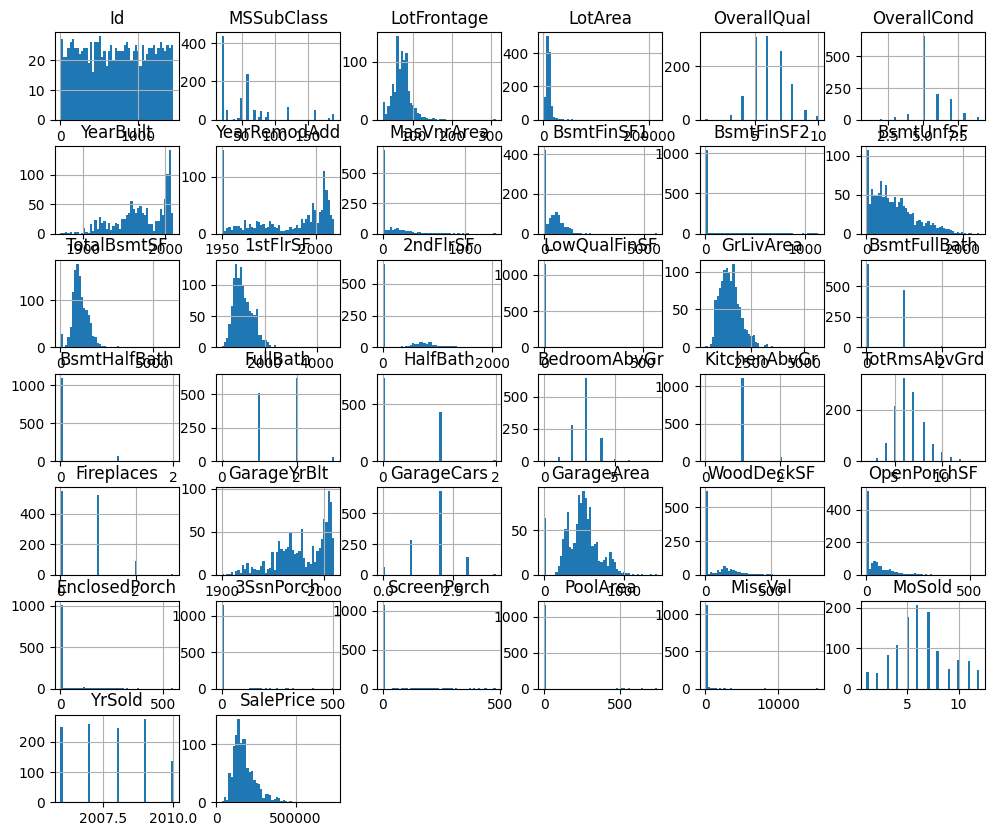

In [131]:
exploration_set.hist(bins=50, figsize=(12,10))

# 4. Data Preprocessing

###  Data cleaning- Handling missing values

In [132]:
#Finding missing values
(X_train.isna().sum()/X_train.shape[0]).sort_values(ascending=False).head(20)
#Dropping columns with more than 50% missing values
X_train=X_train.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1)

We can observe that 'PoolQC','MiscFeature','Alley','Fence','FireplaceQu' have high percentage of missing values. Hence we need to drop them. We need to impute other columns.

### Data preprocessing Pipeline

**Imputation and Encoding**

In [133]:
numeric_cols = [ 'LotFrontage', 'LotArea',  'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath','GarageYrBlt', 'FullBath','HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd','Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF','OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea','MiscVal']

categorical_cols = ['MSSubClass','MSZoning','OverallQual','OverallCond', 'Street',  'LotShape', 'LandContour', 'Utilities','LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2','BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual','Functional',  'GarageType', 'GarageFinish', 'GarageQual','GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition', 'MoSold', 'YrSold']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))   
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
impute_encode = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
        
    ],sparse_threshold=0)

In [134]:
'''for col in X_train.columns:
    if col not in numeric_cols and col not in categorical_cols:
        print(col)'''

'for col in X_train.columns:\n    if col not in numeric_cols and col not in categorical_cols:\n        print(col)'

In [135]:
#len(numeric_cols)+len(categorical_cols)

**The Final Preprocessing Pipeline**

In [136]:

data_preprocessing = Pipeline(steps=[('impute_encode', impute_encode),
                                     ('scaler', StandardScaler()),
                                     ])


### Functions for Model Evaluation with cross validation

In [137]:
def train_regressor(estimator, X_train, y_train, cv, name):
  estimator.fit(X_train, y_train)
  cv_results = cross_validate(estimator,
                              X_train, 
                              y_train, 
                              cv=cv,
                              scoring="r2",
                              return_train_score=True,
                              return_estimator=True)
  train_score = cv_results["train_score"]
  test_score = cv_results["test_score"]
  print(f"Average Train r2 Score : {train_score.mean():.2f} +/- {train_score.std():.2f}")
  print(f"Average Test r2 Score: {test_score.mean():.2f} +/- {test_score.std():.2f}")



In [138]:
def eval(estimator, X_test, y_test):
  y_pred = estimator.predict(X_test)
  error = r2_score(y_test, y_pred)
  print(f"r2 score on Test data: {error:.2f}")

In [139]:
cv = 5 #ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Models for Training

## Model 1: Linear Regression

In [140]:
lin_reg_pipeline = Pipeline(steps=[('preprocessing', data_preprocessing),
                                 ('model', LinearRegression())])


## Model2: DecisionTreeRegressor

In [141]:
dt_reg_pipeline = Pipeline([('preprocessing', data_preprocessing),
                            ("dt_reg", DecisionTreeRegressor(random_state = 42))])

## Model 3 : BaggingRegressor

In [142]:
bagging_regressor_pipeline =Pipeline(steps=[('preprocessing', data_preprocessing),
                                     ('mod',BaggingRegressor( random_state=42))
                                     ])

## Model 4: RandomForestRegressor

In [143]:
random_forest_pipeline=Pipeline(steps=[('preprocessing', data_preprocessing),
                                     ('mod',RandomForestRegressor(n_estimators=100, random_state=42))
                                     ])

## Model 5: GradientBoostingRegressor

In [144]:

gradient_boosting_pipeline=Pipeline(steps=[('preprocessing', data_preprocessing),
                                        ('mod',GradientBoostingRegressor(n_estimators=100, random_state=42))
                                        ])

## Model 6: adaboost

In [145]:
ada_boost_pipeline=Pipeline(steps=[('preprocessing', data_preprocessing),
                                        ('mod',AdaBoostRegressor(n_estimators=100, random_state=42))
                                        ])


## Model 7: XGBoost

In [146]:
xgb_pipeline=Pipeline(steps=[('preprocessing', data_preprocessing),
                                        ('mod',XGBRegressor(n_estimators=100, random_state=42))
                                        ])


## Model evaluation

In [147]:

model_pipelines = [lin_reg_pipeline, dt_reg_pipeline, bagging_regressor_pipeline, random_forest_pipeline, gradient_boosting_pipeline, ada_boost_pipeline, xgb_pipeline]
model_names = ["Linear Regression", "Decision Tree Regressor", "Bagging Regressor", "Random Forest Regressor", "Gradient Boosting Regressor", "Ada Boost Regressor", "XGB Regressor"]

for model_pipeline, model_name in zip(model_pipelines, model_names):
  print(model_name)
  train_regressor(model_pipeline, X_train, y_train, cv=5, name=model_name)
  eval(model_pipeline, X_test, y_test)
  print()

Linear Regression
Average Train r2 Score : 0.95 +/- 0.01
Average Test r2 Score: -783188300354879701909504.00 +/- 1007465302790487016472576.00
r2 score on Test data: -86088981688156491350016.00

Decision Tree Regressor
Average Train r2 Score : 1.00 +/- 0.00
Average Test r2 Score: 0.62 +/- 0.09
r2 score on Test data: 0.79

Bagging Regressor
Average Train r2 Score : 0.97 +/- 0.00
Average Test r2 Score: 0.80 +/- 0.06
r2 score on Test data: 0.88

Random Forest Regressor
Average Train r2 Score : 0.98 +/- 0.00
Average Test r2 Score: 0.83 +/- 0.06
r2 score on Test data: 0.89

Gradient Boosting Regressor
Average Train r2 Score : 0.97 +/- 0.00
Average Test r2 Score: 0.85 +/- 0.04
r2 score on Test data: 0.91

Ada Boost Regressor
Average Train r2 Score : 0.87 +/- 0.01
Average Test r2 Score: 0.75 +/- 0.06
r2 score on Test data: 0.78

XGB Regressor
Average Train r2 Score : 1.00 +/- 0.00
Average Test r2 Score: 0.82 +/- 0.05
r2 score on Test data: 0.90



**Model Comparision:**
We can find that model performed best on Gradient Boosting Regressor. But it also performed comparitively well on XGB Regressor.
But it performed poorly on simple linear regression model but better on tree based algorithms and best on boosting models.
Hence Gradient Boosting Regressor used for tuning and final prediction.

## Hyper parameter tuning for the best model- gradient boosting

In [148]:

param_grid = {
    'mod__n_estimators': [100, 200, 300],
    'mod__max_depth': [None, 5, 10, 15],
    'mod__min_samples_split': [2, 5, 10]
}

grid_search=GridSearchCV(gradient_boosting_pipeline, param_grid, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=3)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'mod__max_depth': 5, 'mod__min_samples_split': 10, 'mod__n_estimators': 300}


### Retraing Model with Best Parameters from HPT

In [154]:
gradient_boosting_pipeline=Pipeline(steps=[('preprocessing', data_preprocessing),
                                        ('mod',GradientBoostingRegressor(n_estimators=300, max_depth=5,min_samples_split=10, random_state=42))
                                        ])
gradient_boosting_pipeline.fit( X_train, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('impute_encode',
                                  ColumnTransformer(sparse_threshold=0,
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer())]),
                                                                   ['LotFrontage',
                                                                    'LotArea',
                                                                    'YearBuilt',
                                                                    'YearRemodAdd',
                                                                    'MasVnrArea',
                                                                    'BsmtFinSF1',
                                                                    'BsmtFinSF2',
                                                                    'BsmtUnfSF',
                                                                    'TotalBsmtSF',
                                                                    '1stFlrSF',
                                                                    '2ndFlrSF',
                                                                    'LowQualFinSF',
                                                                    'GrLivArea',
                                                                    'BsmtFullBath'...
                                                                    'BldgType',
                                                                    'HouseStyle',
                                                                    'RoofStyle',
                                                                    'RoofMatl',
                                                                    'Exterior1st',
                                                                    'Exterior2nd',
                                                                    'ExterQual',
                                                                    'ExterCond',
                                                                    'Foundation',
                                                                    'BsmtQual',
                                                                    'BsmtCond',
                                                                    'BsmtExposure',
                                                                    'BsmtFinType1',
                                                                    'BsmtFinType2',
                                                                    'Heating',
                                                                    'HeatingQC',
                                                                    'CentralAir', ...])])),
                                 ('scaler', StandardScaler())])),
                ('mod',
                 GradientBoostingRegressor(max_depth=5, min_samples_split=10,
                                           n_estimators=300,
                                           random_state=42))])

In [155]:
train_regressor(gradient_boosting_pipeline , X_train, y_train, cv, 'Gradient Boosting Regressor')
eval(gradient_boosting_pipeline, X_test, y_test)


Average Train r2 Score : 1.00 +/- 0.00
Average Test r2 Score: 0.85 +/- 0.04
r2 score on Test data: 0.90


### Final Prediction with best Model

In [151]:
final_prediction=gradient_boosting_pipeline.predict(test_data)

In [152]:
submission=pd.DataFrame(columns=['Id','SalePrice'])
submission['Id']=test_data['Id']
submission['SalePrice']=final_prediction
submission.to_csv('submission.csv',index=False)

In [153]:
submission.shape

(1459, 2)